### How Are We Doing?

In the last notebook, you created a working version of SVD for situations even when there are tons of missing values.  This is awesome!  The question now is how well does this solution work?

In this notebook, we are going to simulate exactly what we would do in the real world to tune our recommender.  

Run the cell below to read in the data and get started.

In [22]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the datasets
movies = pd.read_csv('data/movies_clean.csv')
reviews = pd.read_csv('data/reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

1. Using the **reviews** dataframe, perform the following tasks to create a training and validation set of data we can use to test the performance of your SVD algorithm using **off-line** validation techniques.

 * Order the reviews dataframe from earliest to most recent 
 * Pull the first 10000 reviews from  the dataset
 * Make the first 8000/10000 reviews the training data 
 * Make the last 2000/10000 the test data
 * Return the training and test datasets

In [3]:
reviews.shape

(712337, 23)

In [5]:
reviews.head(3)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [9]:
reviews.sort_values(by=['date'], ascending = True).head(3)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
498923,37287,2171847,6,1362062307,2013-02-28 14:38:27,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
442554,33140,444778,8,1362062624,2013-02-28 14:43:44,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
81920,6338,1411238,6,1362062838,2013-02-28 14:47:18,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
x = reviews.sort_values(by=['date'], ascending = True).head(3)
x.iloc[0:1,:]

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
498923,37287,2171847,6,1362062307,2013-02-28 14:38:27,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
x.iloc[1:3,:]

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
442554,33140,444778,8,1362062624,2013-02-28 14:43:44,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
81920,6338,1411238,6,1362062838,2013-02-28 14:47:18,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
def create_train_test(reviews, order_by, training_size, testing_size):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_size - (int) number of rows in training set
    testing_size - (int) number of columns in the test set
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    total_size = training_size + testing_size
    reviews_10000 = reviews.sort_values(by=[order_by], ascending = True).head(total_size)
    training_df = reviews_10000.iloc[0:training_size,:]
    validation_df = reviews_10000.iloc[training_size:total_size,:]
    
    return training_df, validation_df

In [13]:
# Nothing to change in this or the next cell
# Use our function to create training and test datasets
train_df, val_df = create_train_test(reviews, 'date', 8000, 2000)

In [14]:
# Make sure the dataframes we are using are the right shape
assert train_df.shape[0] == 8000, "The number of rows doesn't look right in the training dataset."
assert val_df.shape[0] == 2000, "The number of rows doesn't look right in the validation dataset"
assert str(train_df.tail(1)['date']).split()[1] == '2013-03-15', "The last date in the training dataset doesn't look like what we expected."
assert str(val_df.tail(1)['date']).split()[1] == '2013-03-18', "The last date in the validation dataset doesn't look like what we expected."
print("Nice job!  Looks like you have written a function that provides training and validation dataframes for you to use in the next steps.")

Nice job!  Looks like you have written a function that provides training and validation dataframes for you to use in the next steps.


In [25]:
train_df.user_id.nunique()

3278

In [52]:
train_df.movie_id.nunique()

2679

In [26]:
val_df.user_id.nunique()

1241

In [28]:
len(np.intersect1d(reviews.user_id.unique(),train_df.user_id.unique()))

3278

In [29]:
len(np.intersect1d(val_df.user_id.unique(),train_df.user_id.unique()))

724

In the real world, we might have all of the data up to this final date in the training data.  Then we want to see how well we are doing for each of the new ratings, which show up in the test data.

Below is a working example of the function created in the previous example you can use (or you can replace with your own).

`2.`  Fit the function to the training data with the following hyperparameters: 15 latent features, a learning rate of 0.005, and 250 iterations. This will take some time to run, so you may choose fewer latent features, a higher learning rate, or fewer iteratios if you want to speed up the process.  

**Note:** Again, this might be a good time to take a phone call, go for a walk, or just take a little break.  No need to change the code below unless you would like to make changes to reduce the time needed to obtain results.

In [20]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = n_users * n_movies
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)  # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    user_movie_index = []
    for user_i in range(n_users):
        for movie_j in range(n_movies):
            if(math.isnan(ratings_mat[user_i,movie_j])==False):
                user_movie_index.append([user_i,movie_j])

    sse = []
    for t in range(iters):
        
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        
        for pairs in user_movie_index:
            user_i = pairs[0]
            movie_j = pairs[1]

            # dot product
            uv_new = np.dot(user_mat[user_i,:], movie_mat[:,movie_j])
            delta = (ratings_mat[user_i, movie_j] - uv_new)
            #print(delta)
            sse_accum += delta**2.0 #sum of the square error

            # was before u1/u2/u3/u4 and then v1/v2/v3/v4
            # here do u1/v1 u2/v2 u3/v3 u4/v4 maybe slightly better but not goof for vectorization
            for k in range(latent_features):
                user_mat[user_i,k] = user_mat[user_i,k] + 2.0 * (delta) * learning_rate * movie_mat[k,movie_j]
                movie_mat[k,movie_j] = movie_mat[k,movie_j] + 2.0 * (delta) * learning_rate * user_mat[user_i,k]  
            

        sse.append(sse_accum)
        if(t%10==0):
            print('iteration {}: sse_accum {}'.format(t+1, sse_accum))
    plt.plot(sse)  
    plt.title('iteration {}: sse_accum {}, learning rate {}'.format(t+1, sse_accum, learning_rate))
    plt.show()
    return user_mat, movie_mat 

In [30]:
train_data_df.head()

movie_id,2844,8133,13427,14142,14538,14872,15163,15324,15400,17925,...,2625030,2635622,2638984,2645104,2645164,2646378,2649128,2735466,2748368,2750600
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# list(train_data_df.index)

In [44]:
# list(train_data_df.columns)

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 85449.67831499227
iteration 11: sse_accum 6135.238040884407
iteration 21: sse_accum 1517.5065014275779
iteration 31: sse_accum 491.9940903255847
iteration 41: sse_accum 189.33837692780452
iteration 51: sse_accum 81.54749904208443
iteration 61: sse_accum 37.93099107138891
iteration 71: sse_accum 18.69270671625005
iteration 81: sse_accum 9.63785925536671
iteration 91: sse_accum 5.151689358912555
iteration 101: sse_accum 2.835840897826934
iteration 111: sse_accum 1.6000893739030755
iteration 121: sse_accum 0.9225133164794465
iteration 131: sse_accum 0.5422407716060638
iteration 141: sse_accum 0.3242817174006055
iteration 151: sse_accum 0.19689032791386743
iteration 161: sse_accum 0.12109985086473046
iteration 171: sse_accum 0.07530938444058537
iteration 181: sse_accum 0.04728561901620696
iteration 191: sse_accum 0.02994953633202134
iteration 201: sse_accum 0.019124377866400994
iteration 211: sse_accum 0.012306

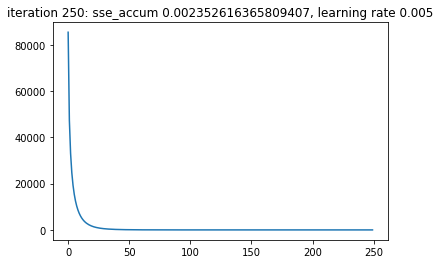

In [23]:
# Create user-by-item matrix - nothing to do here
train_user_item = train_df[['user_id', 'movie_id', 'rating', 'timestamp']]
train_data_df = train_user_item.groupby(['user_id', 'movie_id'])['rating'].max().unstack()
#train_data_df.head()
train_data_np = np.array(train_data_df)  # or train_data_df.values

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, movie_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Now that you have created the **user_mat** and **movie_mat**, we can use this to make predictions for how users would rate movies, by just computing the dot product of the row associated with a user and the column associated with the movie.

`3.` Use the comments in the function below to complete the **predict_rating** function.

In [38]:
user_index = np.array(train_data_df.index)
user_index

array([    8,    46,    48, ..., 53943, 53962, 53966], dtype=int64)

In [41]:
np.where(user_index==8)[0][0]

0

In [42]:
def predict_rating(user_matrix, movie_matrix, user_id, movie_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    movie_matrix - latent factor by movie matrix
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    
    OUTPUT:
    pred - the predicted rating for user_id-movie_id according to FunkSVD
    '''
    user_index = np.array(train_data_df.index)  # actual user index list e.g. [8, 46, 48, 51,...]
    movie_index = np.array(train_data_df.columns) # actual movie index list
    i = np.where(user_index==user_id)[0][0]   # u , ith index
    j = np.where(movie_index==movie_id)[0][0]  # v , jth index
    pred = np.dot(user_matrix[i,:],movie_matrix[:,j]) # k*k don't need to do full multiplication, since nedd one element
   
    return pred

In [43]:
# Test your function with the first user-movie in the user-movie matrix (notice this is a nan)
pred_val = predict_rating(user_mat, movie_mat, 8, 2844)
pred_val

7.761878965416228

It is great that you now have a way to make predictions. However it might be nice to get a little phrase back about the user, movie, and rating.

`4.` Use the comments in the function below to complete the **predict_rating** function.  

**Note:** The movie name doesn't come back in a great format, so you can see in the solution I messed around with it a bit just to make it a little nicer.

In [50]:
def print_prediction_summary(user_id, movie_id, prediction):
    '''
    INPUT:
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    prediction - the predicted rating for user_id-movie_id
    
    OUTPUT:
    None - prints a statement about the user, movie, and prediction made
    
    '''
    print('user_id:           {}'.format(user_id))
    print('movie_id:          {}'.format(movie_id))
    print('rating prediction: {}'.format(np.round(prediction,1)))
    movie_name = movies[movies['movie_id']==movie_id].movie.values[0]
    print('movie name:        {}'.format(movie_name))

In [51]:
# Test your function the the results of the previous function
print_prediction_summary(8, 2844, pred_val)

user_id:           8
movie_id:          2844
rating prediction: 7.8
movie name:        Fantômas - À l'ombre de la guillotine (1913)


Now that we have the ability to make predictions, let's see how well our predictions do on the test ratings we already have.  This will give an indication of how well we have captured the latent features, and our ability to use the latent features to make predictions in the future!

`5.` For each of the user-movie rating in the **val_df** dataset, compare the actual rating given to the prediction you would make.  How do your predictions do?  Do you run into any problems?  If yes, what is the problem?  Use the document strings and comments below to assist as you work through these questions.

In [64]:
val_df.iloc[0:10][['user_id','movie_id']].values[0]

array([  49056, 1598822], dtype=int64)

In [56]:
val_df.iloc[0:10].movie_id.values

array([1598822,  289879, 1563738, 1458175,  103639, 1560985,  287978,
       1028532, 1194173,   43014], dtype=int64)

In [66]:
user_movie_id_list = val_df.iloc[0:10][['user_id','movie_id']].values

In [67]:
for user, movie in user_movie_id_list:
    print(user, movie)

49056 1598822
49056 289879
49056 1563738
49056 1458175
28599 103639
50593 1560985
29000 287978
32541 1028532
9779 1194173
44110 43014


In [78]:
reviews[(reviews['user_id']==49056) & (reviews['movie_id']==1598822)]

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
650588,49056,1598822,8,1363308721,2013-03-15 00:52:01,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [90]:
def validation_comparison(val_df, num_preds):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    num_preds - (int) the number of rows (going in order) you would like to make predictions for
    
    OUTPUT:
    Nothing returned - print a statement about the prediciton made for each row of val_df from row 0 to num_preds
    '''
    user_movie_id_list = val_df.iloc[0:num_preds][['user_id','movie_id']].values # user who reviewed movies
    for user_id, movie_id in user_movie_id_list:
        print(user_id, movie_id)
        prediction = predict_rating(user_mat, movie_mat, user_id, movie_id)
        print_prediction_summary(user_id, movie_id, prediction)
        print(user_id, movie_id)
        rating_actual = reviews[(reviews['user_id']==user_id) & (reviews['movie_id']==movie_id)].rating.values[0]
        print('rating actual: {}'.format(rating_actual))
        print('-----------------------------------------')
# Perform the predicted vs. actual for the first 6 rows.  
validation_comparison(val_df, 6)        

49056 1598822
user_id:           49056
movie_id:          1598822
rating prediction: 7.5
movie name:        New Year's Eve (2011)
49056 1598822
rating actual: 8
-----------------------------------------
49056 289879
user_id:           49056
movie_id:          289879
rating prediction: 8.9
movie name:        The Butterfly Effect (2004)
49056 289879
rating actual: 9
-----------------------------------------
49056 1563738
user_id:           49056
movie_id:          1563738
rating prediction: 7.9
movie name:        One Day (2011)
49056 1563738
rating actual: 9
-----------------------------------------
49056 1458175
user_id:           49056
movie_id:          1458175
rating prediction: 8.0
movie name:        The Next Three Days (2010)
49056 1458175
rating actual: 4
-----------------------------------------
28599 103639
user_id:           28599
movie_id:          103639
rating prediction: 7.2
movie name:        Aladdin (1992)
28599 103639
rating actual: 8
------------------------------------

### 1/6 is far from prediction

In [83]:
# Perform the predicted vs. actual for the first 7 rows.  What happened?
validation_comparison(val_df, 7)        

49056 1598822
user_id:           49056
movie_id:          1598822
rating prediction: 7.5
movie name:        New Year's Eve (2011)
49056 1598822
rating actual: 8
-----------------------------------------
49056 289879
user_id:           49056
movie_id:          289879
rating prediction: 8.9
movie name:        The Butterfly Effect (2004)
49056 289879
rating actual: 9
-----------------------------------------
49056 1563738
user_id:           49056
movie_id:          1563738
rating prediction: 7.9
movie name:        One Day (2011)
49056 1563738
rating actual: 9
-----------------------------------------
49056 1458175
user_id:           49056
movie_id:          1458175
rating prediction: 8.0
movie name:        The Next Three Days (2010)
49056 1458175
rating actual: 4
-----------------------------------------
28599 103639
user_id:           28599
movie_id:          103639
rating prediction: 7.2
movie name:        Aladdin (1992)
28599 103639
rating actual: 8
------------------------------------

IndexError: index 0 is out of bounds for axis 0 with size 0

** A statement about why you think what happened happened.**

## Cold start problem
### The problem is the the user or the movie were not in the training, so atleast one of them is new and was included in original user/matrix unstack for trainig data so is not possible to reconstrcut it
### Based on below observation, movie is the new addition in validation

In [89]:
x = train_data_df.index
print(29000 in x)
y = train_data_df.columns
print(287978 in y)

True
False
